In [41]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## LeNet

The LeNet architecture was first proposed in 1998 (Gradient-Based Learning Applied to
Document Recognition). LeNet was created with the aim of recognizing characters in a document. Here is
a diagram representing its architecture:

<p align = "center">
    <img src = "img/lenet.png">
</p>


Our goal will be to use this architecture to classify FashionMNIST. FashionMNIST images
having a size of 28x28 and not 32x32, it will be necessary to modify the architecture slightly: use a padding of 2 on
the first layer and replace the last layer (gaussian connections) by a dense layer and use
CrossEntropyLoss. These two methods are equivalent, CrossEntropyLoss being more efficient. Layers
of LeNet convolution have kernels of size 5x5. The notion of "subsampling" corresponds to pooling (we
will use maxpooling).

**Question 9.** Implement LeNet and train it on the FashionMNIST dataset. YOU
you can use the code given for the previous exercises. The input images
should be normalized

In [3]:
train_data = torchvision\
    .datasets\
    .FashionMNIST(
        '.',
        train= True,
        transform= transforms.ToTensor(),
        download= True
    )

test_data = torchvision\
    .datasets\
    .FashionMNIST(
        '.',
        train= False,
        transform= transforms.ToTensor(),
        download= True
    )

In [7]:
train_loader = DataLoader(train_data,
                          batch_size=64)
test_loader = DataLoader(test_data,
                         batch_size=64)

In [30]:
class LeNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            padding = 2
        )

        self.subsampling1 = torch.nn.MaxPool2d(
            kernel_size=2
        )

        self.conv2 = torch.nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
        )

        self.subsampling2 = torch.nn.MaxPool2d(
            kernel_size= 2,
        )

        self.fc1 = torch.nn.Linear(
            in_features=16 * 5*5,
            out_features= 120
        )

        self.fc2 = torch.nn.Linear(
            in_features=120,
            out_features= 84
        )
        
        self.fc3 = torch.nn.Linear(
            in_features=84,
            out_features= 10
        )

    def forward(self, x : torch.Tensor):
        x = self.conv1(x)
        # print(f"Shape after first conv: {x.shape}")
        x = self.subsampling1(x)
        # print(f"Shape after first subsampling: {x.shape}")
        x = self.conv2(x)
        # print(f"Shape after second conv: {x.shape}")
        x = self.subsampling2(x)
        # print(f"Shape after second subsampling: {x.shape}")
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        output = self.fc3(x)

        return output

In [31]:
lenet = LeNet()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    lenet.parameters(),
    lr = 1e-4
)

In [32]:
errors = torch.tensor([])

n_epochs = 5
for epoch in tqdm(range(n_epochs)):
    epoch_error = torch.tensor([])
    for X_batch, y_batch in train_loader:
        y_pred = lenet(X_batch)

        loss = loss_fn(y_pred, y_batch)
        epoch_error = torch.cat([epoch_error, torch.tensor([loss.item()])])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    errors = torch.cat([errors, torch.tensor([epoch_error.mean()])])

100%|██████████| 5/5 [01:20<00:00, 16.09s/it]


In [33]:
errors

tensor([0.9133, 0.6251, 0.5703, 0.5300, 0.4990])

In [36]:
success_rate = torch.tensor([])

with torch.no_grad():
    for X_batch, y_batch in test_loader:

        y_pred = lenet(X_batch)

        success_rate = torch\
            .cat([
                success_rate, 
                y_pred.argmax(dim = 1) == y_batch
            ])
            
success_rate.sum()/success_rate.shape[0]

tensor(0.8225)

## Parameter sharing

The parameters of a convolutional neural network consist of a set of filters. Each filter is
limited in space, but extends the full depth of the input volume. Intuitively, the network learns
different types of filters that activate when they see a certain feature such as an edge or a spot
of a color on the first layers. The deeper the layers, the more the patterns represented by each
layer are complex.

**Question 10.** Display the weights of the first layer using the code below. What do you notice ?

In [37]:
import torchvision.models as models
# load pretrained model
alexnet = models.alexnet(pretrained=True)
# access weights from first layer
filter = alexnet.features[0].weight.data
# normalize to [0, 1]
filter = (1/(2*filter.max()))*filter + 0.5

/home/pedro/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pedro/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/pedro/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:11<00:00, 20.4MB/s] 


In [54]:
def show (imgs):
    # if not isinstance(imgs, list):
    #     imgs = [imgs]

    fig, axs = plt.subplots(ncols=2,nrows=len(imgs)//2, )
    
    fig.set_figheight(20)
    fig.set_figwidth(20)
    for i, img in enumerate(imgs):
        # img = img.detach()
        # img = F.to_pil_image(img)
        
        axs[i //2, i%2].imshow(img)
        axs[i//2, i%2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [52]:
len(filter.reshape([64, 11,11,3]))

64

64


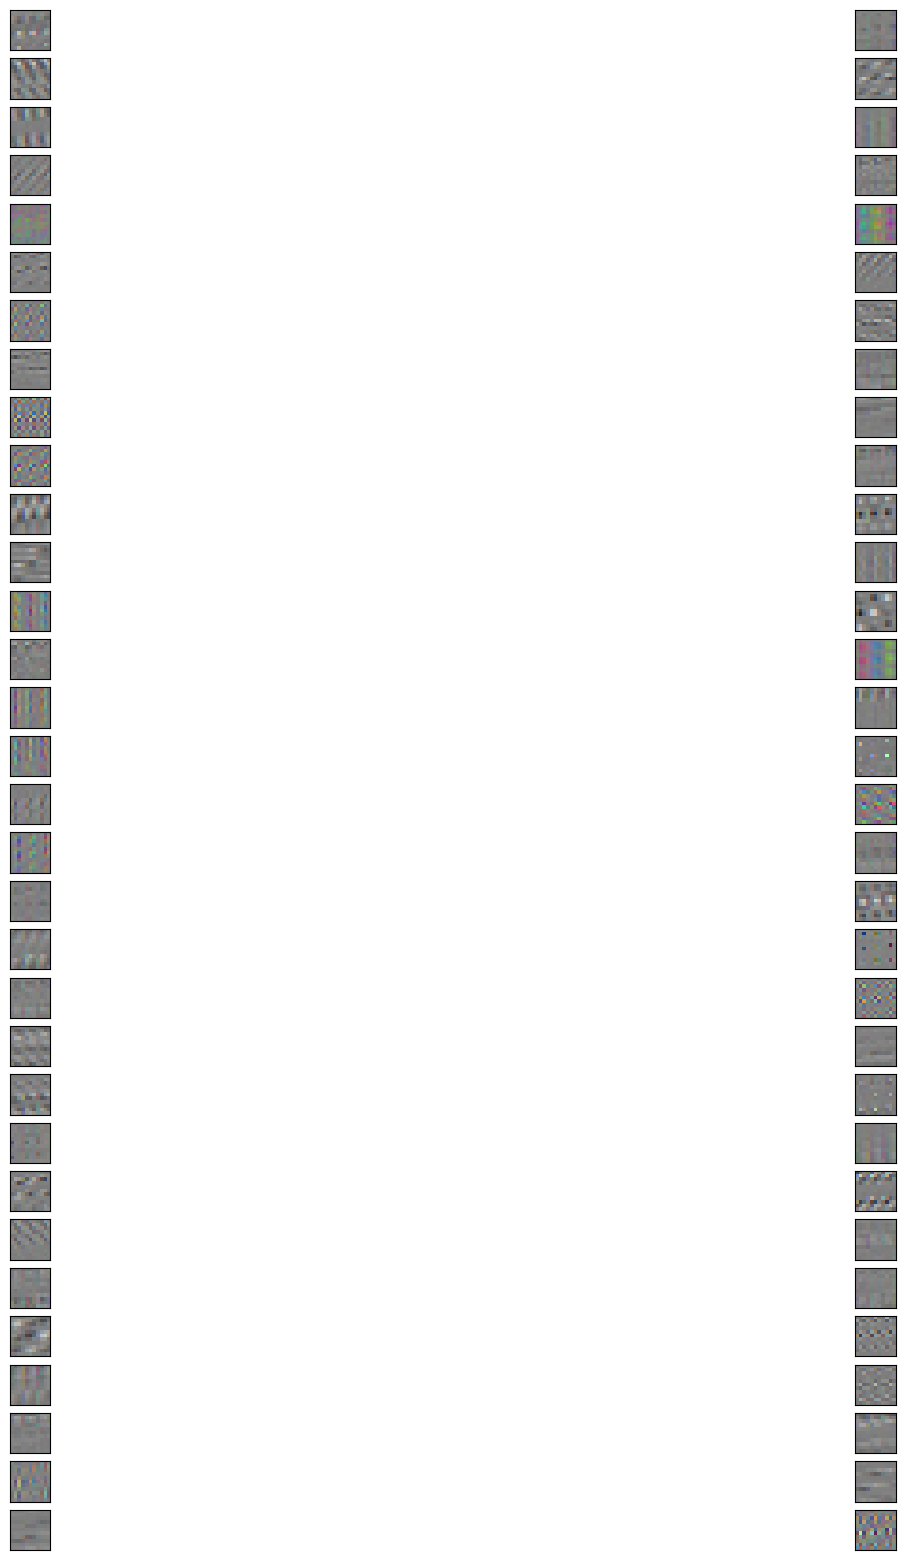

In [55]:
show(filter.reshape([64, 11,11,3]))